In [2]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers

C:\Users\annek\AppData\Local\Temp\ipykernel_12492\4172943127.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


Modified timestamps for file u00065s00001_hw00002.svc:
0     0
1     8
2    15
3    23
4    30
Name: timestamp, dtype: int32




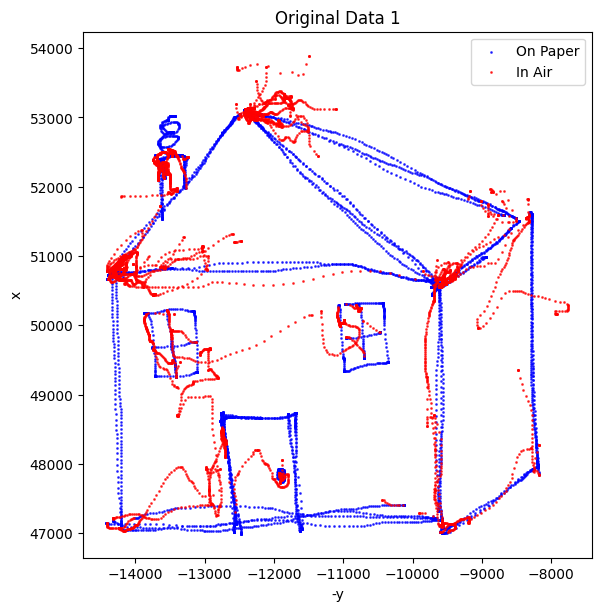

Processed data shape: (11080, 4)
Average number of data points: 11080


In [3]:
# Cell 2 (modified)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3]]  # Select x, y, timestamp, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points

directory = 'Task2'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")


In [4]:
# Cell 3 (VAEGAN Model Definition)

import tensorflow as tf
import numpy as np

class VAEGAN(tf.keras.Model):
    def __init__(self, latent_dim, sequence_length, feature_dim, beta=1.0):
        super(VAEGAN, self).__init__()
        self.latent_dim = latent_dim
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.beta = beta

        # Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(sequence_length, feature_dim)),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(latent_dim * 2)
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(64 * sequence_length),
            tf.keras.layers.Reshape((sequence_length, 64)),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(feature_dim))
        ])

        # Discriminator
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(sequence_length, feature_dim)),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :, :3])
        pen_status = tf.sigmoid(decoded[:, :, 3:])
        return tf.concat([xy_timestamp, pen_status], axis=-1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar

# Loss functions
def compute_reconstruction_loss(model, x, x_reconstructed):
    mse = tf.keras.losses.MeanSquaredError()
    return mse(x, x_reconstructed)

def compute_kl_loss(mean, logvar):
    return -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))

def compute_discriminator_loss(model, x_real, x_fake):
    real_output = model.discriminator(x_real)
    fake_output = model.discriminator(x_fake)
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return tf.reduce_mean(real_loss + fake_loss)

def compute_generator_loss(model, x_fake):
    fake_output = model.discriminator(x_fake)
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

# Training step
@tf.function
def train_step(model, x, optimizer_vae, optimizer_disc):
    with tf.GradientTape() as tape_vae, tf.GradientTape() as tape_disc:
        x_reconstructed, mean, logvar = model(x)
        
        # VAE losses
        reconstruction_loss = compute_reconstruction_loss(model, x, x_reconstructed)
        kl_loss = compute_kl_loss(mean, logvar)
        vae_loss = reconstruction_loss + model.beta * kl_loss
        
        # Discriminator loss
        disc_loss = compute_discriminator_loss(model, x, x_reconstructed)
        
        # Generator loss
        gen_loss = compute_generator_loss(model, x_reconstructed)
        
        # Total loss
        total_loss = vae_loss + gen_loss

    # Compute gradients and apply updates
    gradients_vae = tape_vae.gradient(total_loss, model.encoder.trainable_variables + model.decoder.trainable_variables)
    gradients_disc = tape_disc.gradient(disc_loss, model.discriminator.trainable_variables)
    
    optimizer_vae.apply_gradients(zip(gradients_vae, model.encoder.trainable_variables + model.decoder.trainable_variables))
    optimizer_disc.apply_gradients(zip(gradients_disc, model.discriminator.trainable_variables))

    return total_loss, reconstruction_loss, kl_loss, disc_loss, gen_loss

In [5]:
# Cell 4 (Training Loop with Per-Epoch Visualization)

import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 256
sequence_length = avg_data_points
feature_dim = 4  # x, y, timestamp, pen_status
beta = 0.0000001
learning_rate_vae = 0.001
learning_rate_disc = 0.001
batch_size = 512
epochs = 100
early_stopping_patience = 50
min_delta = 0.0001

# Padding function
def pad_sequence(seq, max_length):
    return np.pad(seq, ((0, max_length - len(seq)), (0, 0)), mode='constant')
# Find the maximum sequence length
max_sequence_length = max(df.shape[0] for df in data_frames)

# Pad all sequences to the maximum length
padded_data = np.array([pad_sequence(df.values, max_sequence_length) for df in data_frames])

# Reshape the data


# Update hyperparameters
sequence_length = max_sequence_length



# Create VAEGAN model
# Create VAEGAN model with updated sequence_length
vaegan = VAEGAN(latent_dim, sequence_length, feature_dim, beta)
optimizer_vae = tf.keras.optimizers.Adam(learning_rate_vae)
optimizer_disc = tf.keras.optimizers.Adam(learning_rate_disc)

# Prepare the dataset
combined_data_reshaped = padded_data.reshape(-1, max_sequence_length, feature_dim)
# Prepare the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(combined_data_reshaped).shuffle(10000).batch(batch_size)

# Update the visualize_augmented_data function
def visualize_augmented_data(epoch, original_data, model):
    plt.figure(figsize=(12, 6))
    
    # Plot original data (use the first file for visualization)
    original_data_first = original_data[0]
    original_on_paper = original_data_first[original_data_first[:, 3] == 1]
    original_in_air = original_data_first[original_data_first[:, 3] == 0]
    plt.subplot(1, 2, 1)
    plt.scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
    plt.scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
    plt.title('Original Data (First File)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')

    # Generate and plot augmented data
    z = tf.random.normal(shape=(1, latent_dim))
    augmented_data = model.decode(z).numpy().reshape(-1, feature_dim)
    augmented_on_paper = augmented_data[augmented_data[:, 3] > 0.5]
    augmented_in_air = augmented_data[augmented_data[:, 3] <= 0.5]
    plt.subplot(1, 2, 2)
    plt.scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
    plt.scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
    plt.title(f'Augmented Data (Epoch {epoch+1})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.show()

# Training loop
best_loss = float('inf')
patience_counter = 0
loss_history = {'total': [], 'reconstruction': [], 'kl': [], 'discriminator': [], 'generator': []}

print("Starting training...")
print(f"Total number of batches per epoch: {len(train_dataset)}")

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("--------------------")
    
    epoch_start_time = time.time()
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    disc_loss_sum = 0
    gen_loss_sum = 0
    num_batches = len(train_dataset)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch_idx, batch in enumerate(train_dataset):
            batch_start_time = time.time()
            
            total_loss_batch, reconstruction_loss, kl_loss, disc_loss, gen_loss = train_step(vaegan, batch, optimizer_vae, optimizer_disc)
            
            total_loss += total_loss_batch
            reconstruction_loss_sum += reconstruction_loss
            kl_loss_sum += kl_loss
            disc_loss_sum += disc_loss
            gen_loss_sum += gen_loss
            
            batch_time = time.time() - batch_start_time
            
            # Update progress bar every 10 batches
            if (batch_idx + 1) % 10 == 0 or batch_idx == num_batches - 1:
                pbar.update(10 if batch_idx != num_batches - 1 else num_batches % 10)
                pbar.set_postfix({
                    'Total Loss': f'{float(total_loss_batch):.4f}',
                    'Recon Loss': f'{float(reconstruction_loss):.4f}',
                    'KL Loss': f'{float(kl_loss):.4f}',
                    'Disc Loss': f'{float(disc_loss):.4f}',
                    'Gen Loss': f'{float(gen_loss):.4f}',
                    'Batch Time': f'{batch_time:.2f}s'
                })
                
            # Print detailed log every 100 batches
            if (batch_idx + 1) % 100 == 0:
                print(f"\nBatch {batch_idx + 1}/{num_batches}:")
                print(f"  Total Loss: {float(total_loss_batch):.6f}")
                print(f"  Reconstruction Loss: {float(reconstruction_loss):.6f}")
                print(f"  KL Loss: {float(kl_loss):.6f}")
                print(f"  Discriminator Loss: {float(disc_loss):.6f}")
                print(f"  Generator Loss: {float(gen_loss):.6f}")
                print(f"  Batch processing time: {batch_time:.2f} seconds")

    # Calculate average losses
    avg_total_loss = total_loss / num_batches
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches
    avg_disc_loss = disc_loss_sum / num_batches
    avg_gen_loss = gen_loss_sum / num_batches

    # Update loss history
    loss_history['total'].append(avg_total_loss)
    loss_history['reconstruction'].append(avg_reconstruction_loss)
    loss_history['kl'].append(avg_kl_loss)
    loss_history['discriminator'].append(avg_disc_loss)
    loss_history['generator'].append(avg_gen_loss)

    epoch_time = time.time() - epoch_start_time
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Total Loss: {avg_total_loss:.6f}")
    print(f"  Reconstruction Loss: {avg_reconstruction_loss:.6f}")
    print(f"  KL Loss: {avg_kl_loss:.6f}")
    print(f"  Discriminator Loss: {avg_disc_loss:.6f}")
    print(f"  Generator Loss: {avg_gen_loss:.6f}")
    print(f"  Epoch processing time: {epoch_time:.2f} seconds")

    # Early stopping check
    if avg_total_loss < best_loss - min_delta:
        best_loss = avg_total_loss
        patience_counter = 0
        print("  New best loss achieved!")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{early_stopping_patience}")

    # Visualize augmented data after each epoch
    print("\nGenerating and visualizing augmented data for this epoch...")
    visualize_augmented_data(epoch, combined_data, vaegan)

    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\nTraining completed.")

# Plot loss history
plt.figure(figsize=(12, 8))
for loss_type, loss_values in loss_history.items():
    plt.plot(loss_values, label=loss_type.capitalize())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

print("Final visualization of augmented data:")
visualize_augmented_data(epochs-1, combined_data, vaegan)

print("Visualization complete.")

C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Starting training...
Total number of batches per epoch: 1

Epoch 1/100
--------------------


Epoch 1/100:   0%|          | 0/1 [00:00<?, ?batch/s]